# Transfer Learning
* https://www.youtube.com/watch?v=K0lWSB2QoIQ&list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4&index=15
* 以下の機能を学習
  * ImageFolder
  * Scheduler - to change the learning_rate
  * Transfer Learning

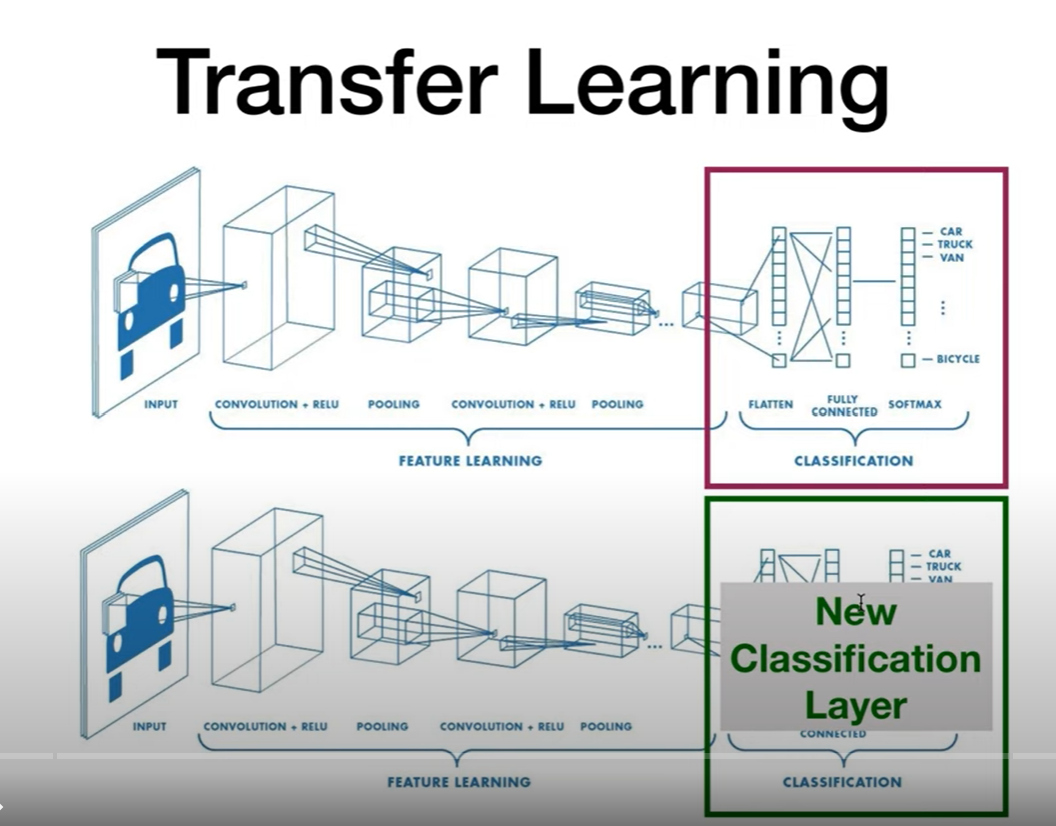

In [3]:
from PIL import Image
im = Image.open('/content/drive/MyDrive/study_DeepLearning/data/png/transfer_learning.png')
im

In [ ]:
# getting the dataset in
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

# unzipping the dataset
!unzip hymenoptera_data.zip

--2024-05-13 07:50:17--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.164.154.30, 18.164.154.17, 18.164.154.37, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.164.154.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   240MB/s    in 0.2s    

2024-05-13 07:50:18 (240 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data

In [ ]:
from typing_extensions import dataclass_transform
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms  = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

In [ ]:
data_dir = '/content/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['ants', 'bees']


In [ ]:
print(type(dataloaders))
print(type(dataloaders['train']))
for x, y in dataloaders['train']:
    print(x.shape)
    print(y.shape)
    break
for x, y in dataloaders['val']:
    print(x.shape)
    print(y.shape)
    break

<class 'dict'>
<class 'torch.utils.data.dataloader.DataLoader'>
torch.Size([4, 3, 224, 224])
torch.Size([4])
torch.Size([4, 3, 224, 224])
torch.Size([4])


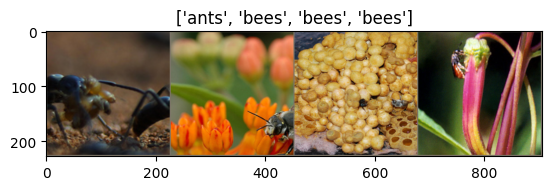

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor"""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    plt.show()

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # foward
                # trach history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # set_grad_enabled()で勾配の計算をするかしないかのon/offができる
                    # これでoffの時は、torch.no_gradと同じ状態になる
                    # torch.set_grad_enabled(True)で勾配を計算する
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Transfer learning of whole layer re-tuning.

In [ ]:
#### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.
# ※※※resnet18のすべての層のパラメータを再チューニングする！！！

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learining rate scheduling should be applied after optimizer's update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 48.4MB/s]


Epoch 0/24
----------
train Loss: 0.6230 Acc: 0.6352
val Loss: 0.4651 Acc: 0.8301

Epoch 1/24
----------
train Loss: 0.5302 Acc: 0.7295
val Loss: 0.3656 Acc: 0.8693

Epoch 2/24
----------
train Loss: 0.4213 Acc: 0.8238
val Loss: 0.2946 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.4316 Acc: 0.8197
val Loss: 0.2740 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.4150 Acc: 0.7992
val Loss: 0.2440 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.4194 Acc: 0.7951
val Loss: 0.2391 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.3731 Acc: 0.8197
val Loss: 0.2254 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.3580 Acc: 0.8566
val Loss: 0.2253 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3401 Acc: 0.8525
val Loss: 0.2145 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3537 Acc: 0.8566
val Loss: 0.2289 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.4249 Acc: 0.7910
val Loss: 0.2097 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3582 Acc: 0.8320
val Loss: 0.2132 Acc: 0.9281

Ep

### Detail of Transfer learning of whole layer tuning.
```
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)
```

<br>

1. **Load a Pre-trained Model**:
```
model = models.resnet18(pretrained=True)
```
    * **ResNet18**: A convolutional neural network architecture that is 18 layers deep.
    * **pretrained=True**: Load a model pre-trained on the ImageNet dataset (which contains millions of images across 1000 classes). This model has already learned useful features from a large dataset.

2. **Modify the Final Layer**:
```
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
```
    * **model.fc.in_features**: Get the number of input features to the final fully connected layer(**`fc`**). For ResNet18, this is typically 512.
    * **nn.Linear(num_ftrs, 2)**: Replaced the final layer with a new **`nn.Linear`** layer that has **`num_ftrs`** input features and 2 output features (since our target dataset has 2 classes).

#### Explanation
1. **ResNet18 Architecture**:
    * ResNet18 is a convolutional neural network(CNN) architecture that has 18 layers. It ends with a fully connected (fc) layer that is used to make the final classification decision.
    * When you load the pre-trained ResNet18 model with **`models.resnet18(pretrained=True)`**, it includes a fully connected layer (**`model.fc`**) that is configured for the ImageNet dataset, which has 1000 classes.
2. **Accessing the Last Layer**:
```
num_ftrs = model.fc.in_features
```
    * **`model.fc`** refers to the final fully connected layer of the ResNet18 model.
    * **`model.fc.in_features`** retrieves the number of input features for this fully connected layer. For ResNet18, this number is typically 512.

3. **Replacing the Last Layer**:
```
model.fc = nn.Linear(num_ftrs, 2)
```
    * **`nn.Linear(num_ftrs, 2)`** creates a new fully connected layer with **`num_ftrs`** input features and 2 output features.
    * This line replaces the original **`fc`** layer of ResNet18 with this new layer, effectively changing the number of output classes from 1000 (used for ImageNet) to 2 (for your specific task).

#### Why Replace the Last Layer?
* **Transfer Learning**: The idea behind transfer learning is to leverage the features learned by a model pre-trained on a large dataset(like ImageNet) and fine-tune it for a smaller, task-specific dataset.
* **Task-Specific Output**: Since your target dataset has 2 classes, you need the final output layer to have 2 output features (one for each classe). This replacement ensures the model's output matches the number of classes in your dataset.

#### Summary
By executing the code:
```
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
```
* You are accessing the existing fully connected layer of the pre-trained ResNet18 model.
* You are replacing this layer with a new fully connected layer that has the same number of input features but outputs predictions for 2 classes instead of the original 1000 classes.


Ths process adapts the pre-trained model to your specific classification task, allowing it to learn and predict the classes in your target dataset.

## Transfer learning of last layer re-tuning.

In [ ]:
#### ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
# ※※※resnet18の最後の層のパラメータのみチューニングする！！！
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5797 Acc: 0.6557
val Loss: 0.3265 Acc: 0.8366

Epoch 1/24
----------
train Loss: 0.4075 Acc: 0.8074
val Loss: 0.1818 Acc: 0.9542

Epoch 2/24
----------
train Loss: 0.7012 Acc: 0.7459
val Loss: 0.2179 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.3778 Acc: 0.8402
val Loss: 0.2225 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.4408 Acc: 0.8320
val Loss: 0.3046 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.6258 Acc: 0.7459
val Loss: 0.2117 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.4264 Acc: 0.8320
val Loss: 0.4019 Acc: 0.8497

Epoch 7/24
----------
train Loss: 0.3491 Acc: 0.8443
val Loss: 0.1815 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3141 Acc: 0.8648
val Loss: 0.1996 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.4637 Acc: 0.7787
val Loss: 0.2282 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.4030 Acc: 0.8197
val Loss: 0.2007 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3138 Acc: 0.8689
val Loss: 0.2525 Acc: 0.9150

Ep

### Detail of Transfer learning of last layer tuning.
```
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)
```

#### **Load a Pre-trained Model and Freeze Parameters**
```
model_conv = torchvision.models.resnet18(pretrained=True)
for params in model_conv.parameters():
    param.requires_grad = False
```
1. **Load Pre-Trained ResNet18 Model**:
```
model_conv = torchvision.models.resnet18(pretrained=True)
```
    * **ResNet18**: A convolutionalneural network architecture that is 18 layers deep.
    * **pretrained=True**: Load a model pre-trained on the ImageNet dataset, which contains millions of images across 1000 classes. This model has already learned useful features from a large dataset.
2. **Freeze Parameters**:
```
for param in model_conv.parameters():
    param.requires_grad = False
```
    * This loop sets the **`requires_grad`** attribute of all parameters in the model to **`False`**.
    * **requires_grad=False**: Ensures that the gradients for these parameters are not computed during backpropagation, effectively freezing the pre-trained weights. This way, during training, only the parameters of the newly added layer will be updated.

#### **MOdify the Final Fully Connected Layer**
```
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
```
1. **Get Number of Input Features**
```
num_ftrs = model_conv.fc.in_features
```
    * **`model_conv.fc.in_features`**: Retrieves the number of input features to the final fully connected layer (**`fc`**). For ResNet18, this is typically 512.
2. **Replace the Fully Connected Layer**:
```
model_conv.fc = nn.Linear(num_ftrs, 2)
```
    * **`nn.Linear(num_ftrs, 2)`**: Creates a new fully conneted layer with **`num_ftrs`** input features and 2 output features (since your target dataset has 2 classes).
    * This line replace the original **`fc`** layer of ResNet18 with the new layer.


#### **Define Loss Function, Optimizer, and Learning Rate Scheduler**
```
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
```
1. **Loss Function**:
```
criterion = nn.CrossEntropyLoss()
```
    * **CrossEntropyLoss** : A common loss function for classification problems. It combines **`nn.LogSoftmax()`** and **`nn.NLLLoss()`** in one single class.

2. **Optimizer**:
```
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
```
    * **SGC (Stochastic Gradient Descent)**: An optimization algorithm used to update the model's parameters.
    * <u>**`model_conv.fc.parameters()`**: Specifies that only the parameters of the final fully connected layer will be updated</u>.
    * **lr=0.001**: The learning rate for the optimizer, which controls the step size during parameter updates.
    * **momentum=0.9**: A parameter that helps accelerate the optimizer in the relevant direction and dampen(弱める) oscillations(振動).

3. **Learning Rate Scheduler**:
```
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
```
    * **StepLR**: A learning rate scheduler that decays the learning rate by a factor of **`gamma`** every **`step_size`** epochs.
    * **step_size=7**: The number of epochs between each decay of the learning rate.
    * **gammga=0.1**: The factor by which the learning rate is reduced (in this case, the learning rate is multiplied by 0.1 every 7 epochs).


This approach allows the pre-trained ResNet18 model to act as a fixed feature extractor, using its pre-learned features from ImageNet while only fine-tuning the final classification layer for your specific task. This is particularly useful when you have a smaller dataset, as it requires less data and computational resources than fine-tuning the entire model.

# Difference between whole re-training and  only last layer re-training

When all the layer of the model are re-trained, the model can adjust all of its weights based on your new dataset, potentially leading to better performance but requiring more data and computational resources.
On the other hand, Only the final fully connected layer is trained on the new dataset, which requires fewer resources and can be effective when the new dataset is small.

## Summary
* The entire ResNet18 model is fine-tuned, which involves updating the weights of all layers. This approach can yield better performance if you have sufficient data and computational resources but is more complex and resource-intensive.

* The ResNet18 model is used as a fixed feature extractor, and only the final fully connected layer is trained. This approach is simpler and less resource-intensive, suitable for smaller datasets, but may not achieve the same level of performance as full fine-tuning.